# CAT-DOG IMAGE CLASSIFIER

<p><b>Status: <span style=color:orange;>In Progress</span></b></p>

##### LOCATE IMAGE FILE NAMES
Cat : 0 | Dog : 1

In [1]:
import os
import random
import pandas as pd
import numpy as np

data_dir = '../../../data/'
class_list = os.listdir(data_dir)  # get classes based on folder names

filename_list = []

# make a list of the images' file names, cats and dogs
for _class in class_list:
    filename_list_class = os.listdir(data_dir + _class)
    filename_list_class = [(_class + '/' + fname) for fname in filename_list_class if fname.endswith('.jpg')]
    filename_list += filename_list_class

# shuffle the dataset
np.random.seed(45)
np.random.shuffle(filename_list)

# adjust the dataset size
filename_list = filename_list[:300]

print('Total number of files : ', len(filename_list))
filename_list[:10]

Total number of files :  300


['Dog/794.jpg',
 'Cat/11371.jpg',
 'Dog/3937.jpg',
 'Cat/4133.jpg',
 'Dog/4969.jpg',
 'Cat/9435.jpg',
 'Cat/11272.jpg',
 'Dog/2098.jpg',
 'Dog/11725.jpg',
 'Dog/12295.jpg']

##### PREPARE TO STORE DATASET CHARACTERISTICS

In [2]:
# this will store the information from every image
X = []  # feature
y = []  # labels

channels = 3        # three colors: RGB
image_size = 64     # image will be converted to 64x64 images

n_images = len(filename_list)

X = np.ndarray(shape=(n_images, image_size, image_size, channels), dtype=np.float32)

##### EXTRACT IMAGE INFORMATION
This block will read every image to resize them and store their labels


0 invalid file(s) were found

Printing the resulting dataset :

LABEL : Dog


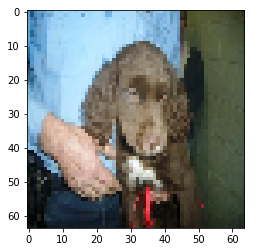


Raw data (first image):


array([[[191., 144.,  82.],
        [138.,  88.,  35.],
        [183., 140.,  87.],
        ...,
        [ 35.,  59.,  51.],
        [ 37.,  58.,  50.],
        [ 28.,  47.,  39.]],

       [[198., 152.,  87.],
        [133.,  84.,  28.],
        [182., 135.,  83.],
        ...,
        [ 36.,  60.,  52.],
        [ 38.,  59.,  51.],
        [ 35.,  50.,  43.]],

       [[207., 162.,  95.],
        [166., 119.,  59.],
        [160., 111.,  60.],
        ...,
        [ 33.,  57.,  49.],
        [ 41.,  63.,  55.],
        [ 47.,  67.,  59.]],

       ...,

       [[ 16.,  14.,  11.],
        [  9.,   8.,   5.],
        [  4.,   4.,   1.],
        ...,
        [ 38.,  48.,  38.],
        [ 33.,  44.,  34.],
        [ 36.,  49.,  38.]],

       [[ 14.,  13.,   9.],
        [ 10.,   9.,   5.],
        [ 17.,  18.,  14.],
        ...,
        [ 36.,  47.,  39.],
        [ 30.,  41.,  31.],
        [ 29.,  43.,  31.]],

       [[ 24.,  24.,  18.],
        [ 20.,  20.,  14.],
        [ 28.,  

In [3]:
%matplotlib inline
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import cv2

# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x


# make a list for the name of failed files
fail_dir_list = []

# count the number of valid images that were read
img_counter = 0

for f in tqdm(range(len(filename_list))):
    try:
        # read every image
        img_path = data_dir + filename_list[f]
        img = cv2.imread(img_path, 1)  # 1 : Color

        # resize every image to the desired size
        img = cv2.resize(img,(image_size,image_size))

        # build the list with feature data [RGB values]
        X[img_counter, :, :, :] = img

        # split image directory name
        fname_split = filename_list[f].split('/')  # =[Cat, 10.jpg] example
        
        # build the list with labels [cats | dogs]
        class_name = fname_split[0]
        y.append(class_name)

        img_counter += 1

    except Exception as e:
        # log names of files with errors
        fail_dir_list.append(fname)
        pass

# remove empty arrays
X = X[:img_counter]

print('{} invalid file(s) were found\n'.format(len(fail_dir_list)))
print('Printing the resulting dataset :\n')

# plot a sample from the list of images [features]
print('LABEL : ' + y[0])
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB).astype(np.uint8))
plt.show()

print('\nRaw data (first image):')
X[0]

##### TRANSFORM THE TARGET VALUES TO ONE-HOT ENCODING

In [4]:
y = pd.get_dummies(y)
y.head()

,Cat,Dog
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1


##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [5]:
from sklearn.model_selection import train_test_split

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=13)

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(np.shape(X_train),
                                                                      np.shape(y_train),
                                                                      np.shape(X_test),
                                                                      np.shape(y_test)))

Data shapes:

X_train : (240, 64, 64, 3)
y_train : (240, 2)

X_test : (60, 64, 64, 3)
y_test : (60, 2)


##### DEFINE NETWORK PARAMETERS

In [6]:
#extract images properties
image_width  = np.shape(X_test)[1]
image_height = np.shape(X_test)[2]
n_channel  = np.shape(X_test)[3]
n_classes = np.shape(y_train)[1]

# count number of samples in each set of data
n_train = np.shape(X_train)[0]
n_test = np.shape(X_test)[0]

# define amount of neurons
n_layer_in = None          # this will depends on the conv layer configurations
n_layer_h1 = 1024          # first   hidden layer
n_layer_h2 = 1024          # second  hidden layer
n_layer_out = n_classes    # 2 neurons in output layer

sigma_init = 0.01   # For randomized initialization

##### MODEL ARCHITECTURE

In [7]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(n_layer_h1))
model.add(Dense(n_classes))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
__________

In [8]:
# initiate RMSprop optimizer
optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 15s 61ms/step - loss: 0.9852 - acc: 0.4938 - val_loss: 0.6924 - val_acc: 0.5167
Epoch 2/10
240/240 [==============================] - 10s 43ms/step - loss: 0.7184 - acc: 0.5271 - val_loss: 0.6909 - val_acc: 0.5083
Epoch 3/10
240/240 [==============================] - 11s 44ms/step - loss: 0.6977 - acc: 0.4792 - val_loss: 0.6885 - val_acc: 0.6083
Epoch 4/10
240/240 [==============================] - 11s 44ms/step - loss: 0.7046 - acc: 0.5625 - val_loss: 0.6788 - val_acc: 0.4750
Epoch 5/10
240/240 [==============================] - 11s 45ms/step - loss: 0.6627 - acc: 0.6167 - val_loss: 0.6725 - val_acc: 0.5333
Epoch 6/10
240/240 [==============================] - 11s 44ms/step - loss: 0.6456 - acc: 0.6292 - val_loss: 0.6304 - val_acc: 0.6167
Epoch 7/10
240/240 [==============================] - 11s 44ms/step - loss: 0.6121 - acc: 0.6688 - val_loss: 0.6242 - val_acc: 0.6250
Epoch 8/10
240/24

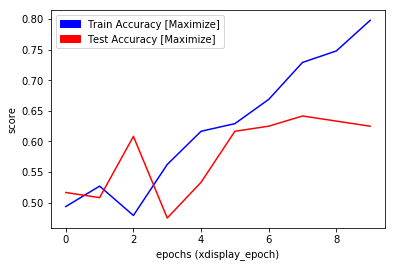

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

#plot the data
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='red')

plt.xlabel('epochs (x{})'.format('display_epoch'))
plt.ylabel('score');